#**Building function to build model:**


*   Resnet Block
*   Densnet Block
*  Upsampling Block
* Convolution Block
* Generator
* Discriminator



In [82]:
!pip install tensorflow-addons
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, Lambda, LeakyReLU, Flatten, Dense,PReLU,Concatenate
from tensorflow.keras.layers import PReLU
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

Convolution Block for generator include 

1.   Conv2D
2.    Activation layer (PRelu, leakyRelu)



In [83]:
def convBlock(inputs,num_ker=64,ker_size=3,active='prelu',strides=1,name='conv'):
   x=Conv2D(filters=num_ker,kernel_size=ker_size,padding='same',strides=strides,name=name)(inputs)
   if active=='prelu':
      x=PReLU(alpha_initializer=tf.constant_initializer(0.2),shared_axes=(1,2),name='PRelu_'+name)(x)
   elif active=='leakyrelu':
      x=LeakyReLU(alpha=0.2,name='leakyRelu_'+name)(x)
   return x   
    

DenseBlock include number (no_conv_block) of ConvBlock with Concatenate layer to implement Dense Architecture

In [84]:
#Residual in residual Dense Block
def DenseBlock(inputs,no_conv_block=5,no_filter=64,ker_size=3,name='denseBlock'):
  x=convBlock(inputs=inputs,num_ker=no_filter,ker_size=ker_size,active='prelu',name='conv.0_'+name)
  for i in range(no_conv_block-1):
    x=Concatenate(trainable=False,axis=-1)([inputs,x])
    if(i<no_conv_block-2):
      inputs=convBlock(inputs=x,num_ker=no_filter,ker_size=ker_size,active='prelu',name='conv.'+str(i+1)+'_'+name)
    else:
      inputs=convBlock(inputs=x,num_ker=no_filter,ker_size=ker_size,active='none',name='conv.'+str(i+1)+'_'+name)
  return inputs

ResnetBlock include number (no_Block) of denseBlock with Add() layer to implement Resnet Architecture, this block also called "RDBB" (Residual in residual dense block)

In [85]:
def ResnetBlock(inputs,no_Block=3,beta=0.2,name='resnetBlock'):
  x=DenseBlock(inputs,name='denseBlock.0_'+name)
  x=Add(trainable=False)([inputs,x*beta])
  for i in range(no_Block-1):
    x=DenseBlock(x,name='denseBlock.'+str(i+1)+'_'+name)
    x=Add(trainable=False)([inputs,x*beta])
  return Add(trainable=False)([inputs,x*beta])

UpsamplingBlock is implemented of Sub-pixel convolution (Shuffle-pixel) to upsampling fearture size

In [86]:
def upsamplingBlock(inputs,input_dimens=64,scale=2,name='shuffle'):
  x=convBlock(inputs,num_ker=input_dimens*(scale**2),ker_size=3,active='prelu',name='conv.0_'+name)
  x=tf.nn.depth_to_space(x, scale)
  x=PReLU(alpha_initializer=tf.constant_initializer(0.2),shared_axes=(1,2),name='PRelu.0_'+name)(x)
  return x

discriminatorConvBlock include convBlock for Discriminator model

In [87]:
def discriminatorConvBlock(inputs,ker_size=3,num_ker=64,with_bn=True,name='convblock'):
  x=convBlock(inputs,ker_size=ker_size,num_ker=num_ker,active='leakyrelu',strides=1,name=name)
  if with_bn:
    x=BatchNormalization(momentum=0.8)(x)
  x=convBlock(x,ker_size=ker_size,num_ker=num_ker,active='leakyrelu',strides=2,name='strided_'+name)
  return x

In [ ]:
tf.keras.backend.clear_session()

Building Generator

In [88]:

def build_generator():
  
  inputs = keras.Input(shape=(None,None, 3), name="img")
  x=x_0=convBlock(inputs,num_ker=64,ker_size=9,active='prelu',name='conv_extraction')
  x=ResnetBlock(x,name='resnetBlock.0')
  for i in range(7):
    x=ResnetBlock(x,name='resnetBlock.'+str(i+1))
  scale=2

  x=convBlock(x,num_ker=64,ker_size=3,active='none',name='conv_mapping')
  x=Add(trainable=False)([x_0,x])
  for i in range(scale):
    x= upsamplingBlock(x,scale=2,input_dimens=64,name='shuffle.'+str(i))
  x=convBlock(x,num_ker=3,ker_size=9,active='prelu',name='conv_recontructed')
  model=keras.Model(inputs,x,name='generator')
  model.summary()
  return model

Building Discriminator

In [89]:

def build_discriminator():
  inputs=keras.Input(shape=(128,128,3),name='img')
  num_ker=64
  x=inputs
  for i in range(4):
    x=discriminatorConvBlock(x,ker_size=3,num_ker=num_ker,with_bn=False,name='conv.'+str(i))
    # x=discriminatorConvBlock(x,ker_size=3,num_ker=128,with_bn=False,name='conv.1')
    # x=discriminatorConvBlock(x,ker_size=3,num_ker=256,with_bn=False,name='conv.2')
    # x=discriminatorConvBlock(x,ker_size=3,num_ker=512,with_bn=False,name='conv.3')
    num_ker=num_ker*2
  x=Flatten()(x)
  x=Dense(1024)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dense(1, activation='sigmoid')(x)
  discriminator=keras.Model(inputs=inputs,outputs=x,name='discriminator')
  discriminator.summary()
  return discriminator

##**Building Loss Function include:**


*   GAN Loss
*   Perceptual Loss



In [194]:
@tf.function
def content_loss(type='l1'):
    """pixel loss"""
    if type == 'l1':
        return tf.keras.losses.MeanAbsoluteError()
    elif type == 'l2':
        return tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'Loss type {} is not recognized.'.format(type))



In [280]:
def featuremap_vgg19(index=5,with_activation=False):
  #vgg19_54, conv 4th before activation, after 5th maxPooling (20 th layers)
  #vgg19_22, conv 2th befor activation, after 2th maxpooling (5th layers) 
    
    vgg19 = tf.keras.applications.VGG19(include_top=False,input_shape=(None,None,3), weights='imagenet')
    if with_activation==False:
      vgg19.layers[index].activation=None
    perceptual_model=tf.keras.Model(inputs=vgg19.input,outputs=vgg19.layers[index].output)
    return perceptual_model

In [294]:
pre=featuremap_vgg19(index=5)
@tf.function
def feature_loss(sr,hr):
   # the input scale range is [0, 1] (vgg is [0, 255]).
   # 12.75 is rescale factor for vgg featuremaps.
    sr = tf.keras.applications.vgg19.preprocess_input(sr * 255.) / 12.75
    hr = tf.keras.applications.vgg19.preprocess_input(hr * 255.) / 12.75
    sr_feature=pre(sr)
    hr_feature=pre(hr)
    loss=tf.keras.losses.MeanAbsoluteError()
    return loss(sr_feature,hr_feature)

  

In [247]:
def ct(criterion='l1', output_layer=54, before_act=True):
    """content loss"""
    if criterion == 'l1':
        loss_func = tf.keras.losses.MeanAbsoluteError()
    elif criterion == 'l2':
        loss_func = tf.keras.losses.MeanSquaredError()
    else:
        raise NotImplementedError(
            'Loss type {} is not recognized.'.format(criterion))
    vgg = tf.keras.applications.VGG19(input_shape=(None, None, 3), include_top=False)

    if output_layer == 22:  # Low level feature
        pick_layer = 5
    elif output_layer == 54:  # Hight level feature
        pick_layer = 20
    else:
        raise NotImplementedError(
            'VGG output layer {} is not recognized.'.format(criterion))

    if before_act:
        vgg.layers[pick_layer].activation = None

    fea_extrator = tf.keras.Model(vgg.input, vgg.layers[pick_layer].output)

    @tf.function
    def content_loss(hr, sr):
        # the input scale range is [0, 1] (vgg is [0, 255]).
        # 12.75 is rescale factor for vgg featuremaps.
        preprocess_sr = tf.keras.applications.vgg19.preprocess_input(sr * 255.) / 12.75
        preprocess_hr = tf.keras.applications.vgg19.preprocess_input(hr * 255.) / 12.75
        sr_features = fea_extrator(preprocess_sr)
        hr_features = fea_extrator(preprocess_hr)

        return loss_func(hr_features, sr_features)

    return content_loss


In [314]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
img = tf.keras.preprocessing.image.load_img(content_path)

In [318]:
img=tf.keras.preprocessing.image.img_to_array(img,dtype='float32')
img1=tfa.image.gaussian_filter2d(img) 

In [320]:
type(img)

numpy.ndarray

In [321]:
img=img/255
img1=img1/255

In [322]:
img=tf.expand_dims(img, axis=0)
img1=tf.expand_dims(img1,axis=0)
fe=feature_loss(img,img1)
print(fe)
print(type(fe))

tf.Tensor(5.4719334, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [324]:
def imshow(image, title=None):
  plt.figure(figsize=(10, 10))
  plt.imshow(image[0,:,:,:])


In [337]:
img2=tfa.image.gaussian_filter2d(img, filter_shape=(11, 11), sigma=0.8) 

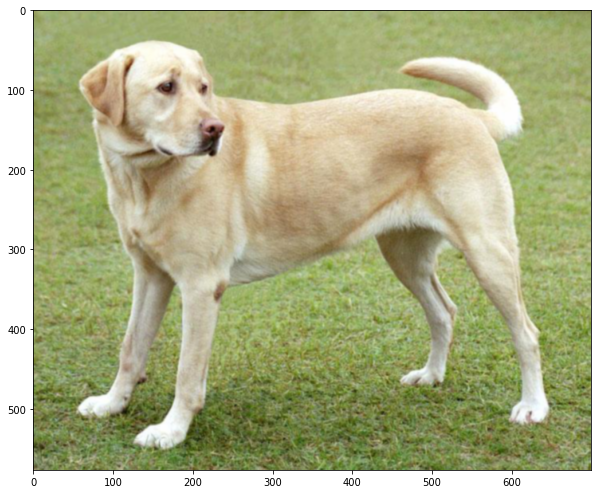

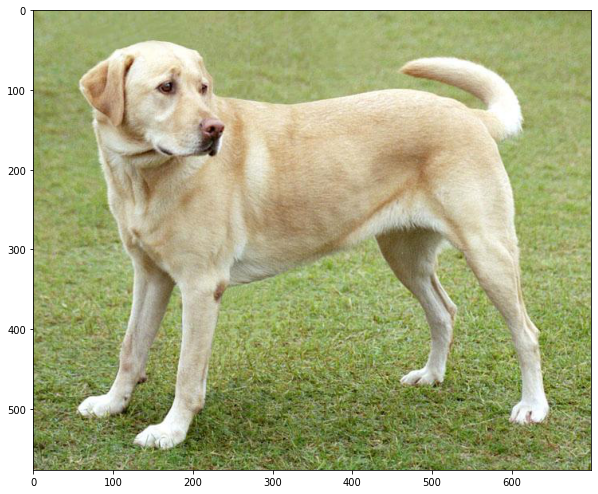

In [338]:
imshow(img2)
imshow(img)

In [165]:
def show_feature(input,number=8,title=None):
  # plot all 64 maps in an 8x8 squares
  square = number
  ix = 1
  plt.figure(figsize=(4*number, 4*number))
  for _ in range(square):
    for _ in range(square):
		# specify subplot and turn of axis
      ax = plt.subplot(square, square, ix)
      ax.set(title=ix)
      plt.imshow(input[0, :, :, ix-1], cmap='gray',aspect='equal')
      ix += 1
  plt.show()
# show the figure

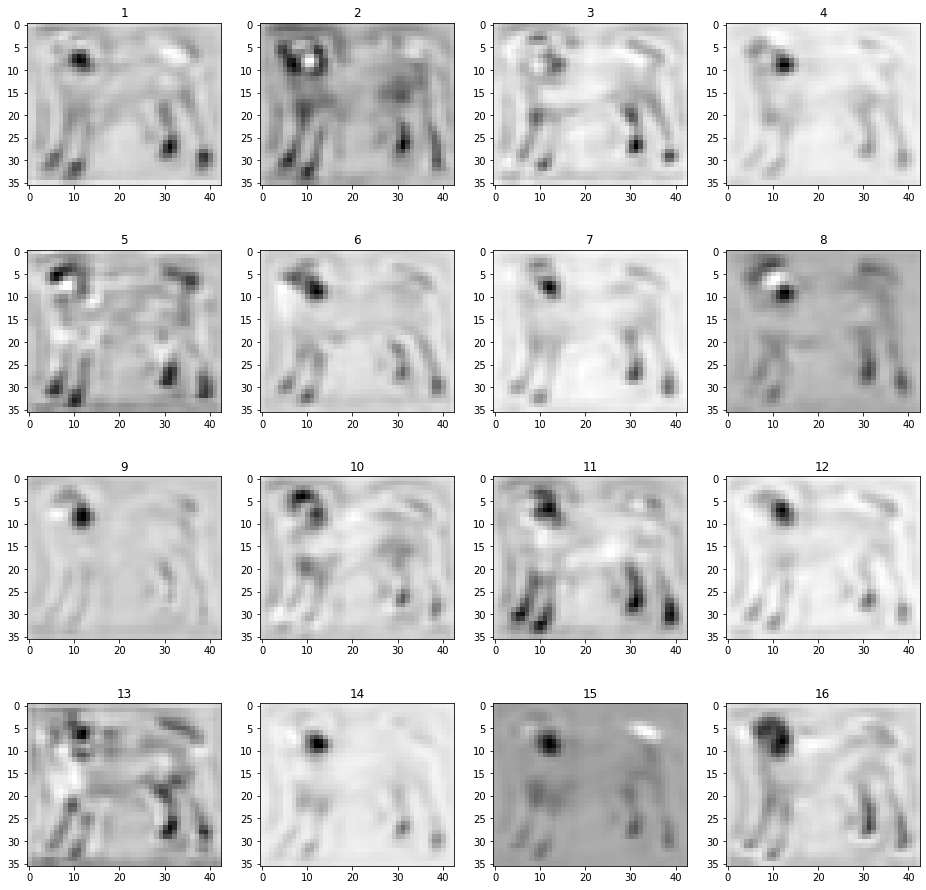

In [174]:
show_feature(fe,number=4)

In [ ]:
!pwd


/content


In [ ]:
 vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
 vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:

def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1

def normalize_01(x):
    return x / 255.0


def denormalize_m11(x):
    return (x + 1) * 127.5

##Testing function for create model

In [ ]:
generator=build_generator()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_extraction (Conv2D)       (None, None, None,   15616       ['img[0][0]']                    
                                64)                                                               
                                                                                                  
 PRelu_conv_extraction (PReLU)  (None, None, None,   64          ['conv_extraction[0][0]']        
                                64)                                                       

In [ ]:
#counting number of layer
no_conv,no_add,no_concatenate,no_activation=0,0,0,0
for i in range(len(generator.layers)):
  if(type(generator.layers[i])==keras.layers.Concatenate):
    no_concatenate=no_concatenate+1
  if(type(generator.layers[i])==keras.layers.Add):
    no_add=no_add+1
  if(type(generator.layers[i])==keras.layers.PReLU):
    no_activation=no_activation+1
  if(type(generator.layers[i])==keras.layers.Conv2D):
    no_conv=no_conv+1
print('total layer: ',len(generator.layers))
print('conv_layer:',no_conv)
print('Add_layer:',no_add)
print('Concatenate_layer:',no_concatenate)
print('Activation_layer:',no_activation)

total layer:  391
conv_layer: 125
Add_layer: 33
Concatenate_layer: 96
Activation_layer: 102


In [ ]:
discriminator=build_discriminator()

In [ ]:
## ploting model
keras.utils.plot_model(generator, "generator.png", show_shapes=True)

In [ ]:
x = tf.random.uniform(shape=[1,10,10,64])
x=conv_normalz_active(x,64,3)
x

##Building GAN model and setup training step

In [ ]:
x.shape

TensorShape([1, 10, 10, 64])

In [ ]:
rank_0_tensor = tf.constant(4)

In [ ]:
print(rank_0_tensor.numpy())

4


In [ ]:
list=[1,2,3]
list.append(4)
list

[1, 2, 3, 4]

In [ ]:
def denseBlock(tensor,n=5,beta=0.2):
  concate_ten=tensor
  for _ in range(n-1):
    x=conv_normalz_active(tensor=concate_ten)
    concate_ten=Concatenate(axis=-1)([concate_ten,x])
  x=conv_normalz_active(tensor=concate_ten)
  return  Add()([tensor, x*beta])

In [ ]:
def mode():
  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  outputs=denseBlock(inputs)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:

tf.keras.backend.clear_session()

In [ ]:
inputs = Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
block_1_output = layers.Conv2D(64, 3, activation="relu")(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = Concatenate(name='concccc')([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = Concatenate()([x, block_2_output])
x=SpectralNormalization(block_3_output)
x = layers.Conv2D(64, 3, activation="relu")(x)
x=layers.PReLU(shared_axes=(1,2))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = Model(inputs, outputs, name="toy_resnet")
model.summary()